# EigenDCGAN

#### Margarita Savova

### Abstract

I introduce a method for initializing random input to a GAN through eigenfaces. The idea behind it is to use eigenfaces as a substitute for the last convolutional layer of a face recognition, which would be the first convolutional layer in a generator in the GAN scenario. We already have a method for extracting representations of different faces, which is the SVD, and I wanted to check if I can generate faces based on a random combination of eigenfaces, which makes the input random as in the original GAN. In my opinion this leads to reduction of the number of parameters in the generator, because we omit the first Dense layer and feed the network with feature maps instead. We can view the inputs as n-dimensional representations of faces in an eigenface coordinate system.

### Setup

In [ ]:
%matplotlib inline

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-l3spb182
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-l3spb182
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.067b315b6bfa13cf6f6d42d4c9fdecc7fa1502c04_-cp37-none-any.whl size=147327 sha256=9f741e2e40e990293e9d63aaa2d81c63ebad097fa2fbc6fe3086d73814b6b10e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qrrts01i/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
import glob
import imageio
import PIL
from PIL import Image
import os, os.path
import imghdr
import time
import gc

import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard

from keras import backend as BK

### Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Images for training

#### Reading the saved dataset

In [ ]:
train_path = os.path.abspath("/content/gdrive/MyDrive/EigenGAN/train")

In [ ]:
# reading the saved dataset

train_dataset = tf.data.experimental.load(train_path, tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32))
for elem in train_dataset:
  print(elem)
  break

tf.Tensor(
[[[[ 106.406       142.23761     121.813705  ]
   [ 105.406       141.23761     120.813705  ]
   [ 106.406       142.23761     121.813705  ]
   ...
   [ 128.406       108.2376       69.813705  ]
   [ 139.406       118.2376       83.813705  ]
   [ 147.406       126.2376       91.813705  ]]

  [[ 107.406       143.23761     122.813705  ]
   [ 107.406       143.23761     122.813705  ]
   [ 106.406       142.23761     121.813705  ]
   ...
   [ 149.406       129.23761      94.813705  ]
   [ 149.406       129.23761      93.813705  ]
   [ 148.406       128.23761      93.813705  ]]

  [[ 106.406       142.23761     121.813705  ]
   [ 107.406       142.23761     121.813705  ]
   [ 106.406       141.23761     121.813705  ]
   ...
   [ 150.406       133.23761      97.813705  ]
   [ 147.406       129.23761      93.813705  ]
   [ 156.406       139.23761     103.813705  ]]

  ...

  [[ -55.594       -55.762398    -25.186295  ]
   [ -56.594       -55.762398    -36.186295  ]
   [ -56.594   

#### Preprocessing

I need to map the images back to 0 to 255 range, because I have previously saved them normalized for a pretrained VGG model.

The initial idea was to use a pretrained VGGface or VGG16 model as a base for the discriminator with Dense layers as the head. I have tried both and in my experience they proved to be unstable and led to very poor performance of the discriminator. Hence I decided to build a discriminator model from scratch and see how it performs.

In [ ]:
def deprocess_images(x_scaled):
  mean = [103.939, 116.779, 123.68]
  b = x_scaled[:, :, :, 0] + mean[0]
  g = x_scaled[:, :, :, 1] + mean[1]
  r = x_scaled[:, :, :, 2] + mean[2]
  x_BGR = tf.stack([b, g, r], axis=3)
  x_RGB = x_BGR[:, :, :, ::-1]
  # x_RGB = tf.cast(x_RGB, dtype=tf.uint8)
  return x_RGB

In [ ]:
train_dataset = train_dataset.map(deprocess_images)

In [ ]:
for elem in train_dataset:
  print(elem)
  print(tf.reduce_min(elem))
  print(tf.reduce_max(elem))
  break

tf.Tensor(
[[[[245.49371  259.0166   210.345   ]
   [244.49371  258.0166   209.345   ]
   [245.49371  259.0166   210.345   ]
   ...
   [193.49371  225.0166   232.345   ]
   [207.49371  235.0166   243.345   ]
   [215.49371  243.0166   251.345   ]]

  [[246.49371  260.0166   211.345   ]
   [246.49371  260.0166   211.345   ]
   [245.49371  259.0166   210.345   ]
   ...
   [218.49371  246.0166   253.345   ]
   [217.49371  246.0166   253.345   ]
   [217.49371  245.0166   252.345   ]]

  [[245.49371  259.0166   210.345   ]
   [245.49371  259.0166   211.345   ]
   [245.49371  258.0166   210.345   ]
   ...
   [221.49371  250.0166   254.345   ]
   [217.49371  246.0166   251.345   ]
   [227.49371  256.0166   260.345   ]]

  ...

  [[ 98.493706  61.0166    48.345   ]
   [ 87.493706  61.0166    47.345   ]
   [ 79.493706  60.0166    47.345   ]
   ...
   [142.49371   72.0166    56.345   ]
   [134.49371   70.0166    52.345   ]
   [122.493706  64.0166    48.345   ]]

  [[100.493706  58.0166    44.345 

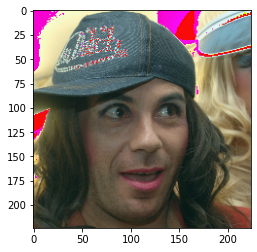

In [ ]:
for elem in train_dataset:
  plt.imshow(tf.cast(elem[0, :, :, :], tf.uint8))
  break

Now I am going to map them between -1 and 1 as an input for the discriminator.

In [ ]:
def normalize_input(train_images):
  center_value = (tf.reduce_max(train_images) - tf.reduce_min(train_images)) / 2
  train_images = (train_images - center_value) / center_value
  return train_images

In [ ]:
train_dataset = train_dataset.map(normalize_input)

In [ ]:
for elem in train_dataset:
  print(elem)
  print(tf.reduce_min(elem))
  print(tf.reduce_max(elem))
  break

tf.Tensor(
[[[[ 0.8016374   0.9008796   0.54368687]
   [ 0.7942986   0.8935408   0.53634804]
   [ 0.8016374   0.9008796   0.54368687]
   ...
   [ 0.42001808  0.6513593   0.7051412 ]
   [ 0.52276176  0.7247476   0.78586835]
   [ 0.5814724   0.7834583   0.84457904]]

  [[ 0.80897623  0.90821844  0.5510257 ]
   [ 0.80897623  0.90821844  0.5510257 ]
   [ 0.8016374   0.9008796   0.54368687]
   ...
   [ 0.6034889   0.80547476  0.8592567 ]
   [ 0.59615004  0.80547476  0.8592567 ]
   [ 0.59615004  0.79813594  0.85191786]]

  [[ 0.8016374   0.9008796   0.54368687]
   [ 0.8016374   0.9008796   0.5510257 ]
   [ 0.8016374   0.8935408   0.54368687]
   ...
   [ 0.6255054   0.8348301   0.8665955 ]
   [ 0.59615004  0.80547476  0.84457904]
   [ 0.6695384   0.8788631   0.9106285 ]]

  ...

  [[-0.27717113 -0.5522093  -0.6452041 ]
   [-0.3578983  -0.5522093  -0.65254295]
   [-0.41660896 -0.5595482  -0.65254295]
   ...
   [ 0.04573758 -0.4714822  -0.58649343]
   [-0.01297308 -0.48615983 -0.6158488 ]
   [-

### Eigenfaces

I am using a different subset of the dataset to produce the eigenmaps. They will be smaller in size than the training data, so they can be upscaled in the generator part.

In [ ]:
eigenfaces_path = os.path.join("/content/gdrive/MyDrive/EigenGAN/eigenfaces/", "eigenfaces.npy")

In [ ]:
# Opening saved eigenfaces

eigen_images = np.load(eigenfaces_path)

In [ ]:
eigen_images.shape

(3072, 56, 56, 3)

In [ ]:
len(eigen_images)

3072

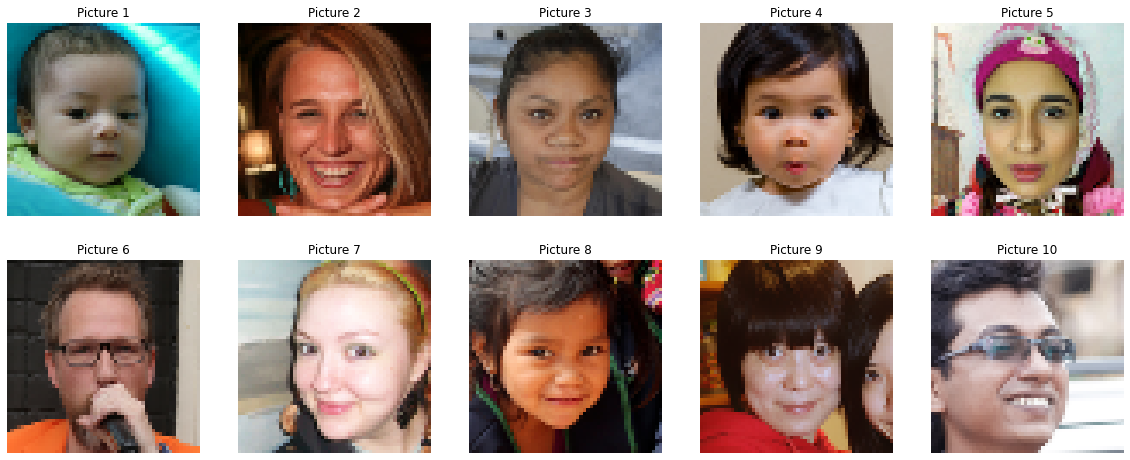

In [ ]:
fig_eigen = plt.figure(figsize = (20, 8))
for j in range(10):
    a = fig_eigen.add_subplot(2, 5, j+1)
    imgplot = plt.imshow(eigen_images[j])
    a.set_title(f'Picture {j+1}')
    plt.axis("off")

In [ ]:
flattened_images = []
for i in range(len(eigen_images)):
  flattened_images.append(tf.reshape(eigen_images[i], [-1]))

In [ ]:
flattened_images[0]

<tf.Tensor: shape=(9408,), dtype=uint8, numpy=array([  0, 127, 144, ..., 132, 156, 160], dtype=uint8)>

In [ ]:
len(flattened_images)

3072

In [ ]:
image_matrix = tf.transpose(tf.stack(flattened_images, 0))
image_matrix.shape

TensorShape([9408, 3072])

In [ ]:
mean_image = tf.math.reduce_mean(image_matrix, axis=1)
mean_image

<tf.Tensor: shape=(9408,), dtype=uint8, numpy=array([127, 122, 114, ..., 115, 103,  99], dtype=uint8)>

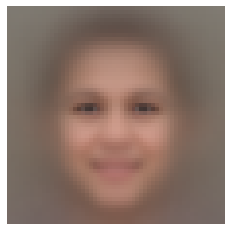

In [ ]:
fig_avg_face = plt.figure(figsize=(4, 4))
plt.imshow(tf.reshape(mean_image, (56, 56, 3)))
plt.axis("off")
plt.show()

In [ ]:
matrix_rows = []
for i in range(len(flattened_images)):
  matrix_rows.append(tf.math.subtract(flattened_images[i], mean_image))

In [ ]:
image_matrix = tf.transpose(tf.stack(matrix_rows, 0))
image_matrix.shape

TensorShape([9408, 3072])

In [ ]:
image_matrix

<tf.Tensor: shape=(9408, 3072), dtype=uint8, numpy=
array([[129, 131,  41, ...,  81, 181, 134],
       [  5, 136,  56, ...,  83, 152, 139],
       [ 30, 142,  75, ..., 105, 167, 147],
       ...,
       [ 17,  86, 207, ...,  30, 170, 235],
       [ 53,  19, 219, ...,  41, 181, 225],
       [ 61, 231, 226, ...,  48, 184, 218]], dtype=uint8)>

In [ ]:
del matrix_rows

In [ ]:
gc.collect()

2719

In [ ]:
image_matrix = tf.cast(image_matrix, dtype=tf.float32)

In [ ]:
#computing the U, S and VT matrices using Singular Value Decomposition
S, U, Vt = tf.linalg.svd(image_matrix)

In [ ]:
U.shape, S.shape, Vt.shape

(TensorShape([9408, 3072]), TensorShape([3072]), TensorShape([3072, 3072]))

Let's check if the product of the matrices is an approximation of the data matrix.

In [ ]:
matrix_approx = tf.matmul(U, tf.matmul(tf.linalg.diag(S), Vt, adjoint_b=True))

In [ ]:
matrix_approx = tf.cast(matrix_approx, dtype=tf.uint8)
matrix_approx

<tf.Tensor: shape=(9408, 3072), dtype=uint8, numpy=
array([[129, 131,  41, ...,  80, 181, 134],
       [  5, 136,  56, ...,  83, 152, 139],
       [ 30, 142,  75, ..., 105, 166, 146],
       ...,
       [ 16,  86, 207, ...,  29, 170, 234],
       [ 52,  19, 219, ...,  41, 181, 225],
       [ 60, 231, 226, ...,  47, 184, 218]], dtype=uint8)>

In [ ]:
U[:, 0]

<tf.Tensor: shape=(9408,), dtype=float32, numpy=
array([-0.00976146, -0.00983736, -0.01045093, ..., -0.00998957,
       -0.010435  , -0.01091257], dtype=float32)>

In [ ]:
tf.reduce_max(U)

<tf.Tensor: shape=(), dtype=float32, numpy=0.096879095>

In [ ]:
tf.reduce_min(U)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.08887539>

In [ ]:
#largest singular value
S[0]

<tf.Tensor: shape=(), dtype=float32, numpy=724075.75>

In [ ]:
# rescaling U in order to visualize eigenfaces with matplotlib

U_rescaled = tf.divide(tf.subtract(U, tf.reduce_min(U)), tf.subtract(tf.reduce_max(U), tf.reduce_min(U)))

In [ ]:
U_rescaled = tf.cast(U_rescaled * 255, dtype=tf.uint8)
U_rescaled

<tf.Tensor: shape=(9408, 3072), dtype=uint8, numpy=
array([[108, 109, 123, ..., 118, 145, 126],
       [108, 107, 125, ..., 129, 113, 131],
       [107, 109, 125, ..., 126, 125, 140],
       ...,
       [108, 115, 117, ..., 121, 113, 111],
       [107, 113, 115, ..., 129, 109, 119],
       [107, 114, 118, ..., 114,  99, 127]], dtype=uint8)>

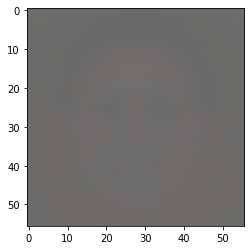

In [ ]:
plt.imshow(tf.reshape(U_rescaled[:, 0], (56, 56, 3)))

In [ ]:
eigenface_1_reshaped = tf.reshape(U_rescaled[:, 0], (56, 56, 3))

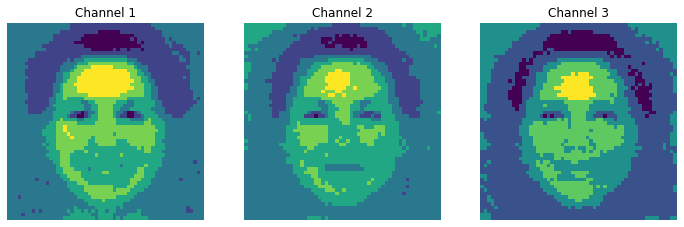

In [ ]:
fig_eigen_1 = plt.figure(figsize = (12, 8))
for i in range(3):
  a = fig_eigen_1.add_subplot(1, 3, i+1)
  imgplot = plt.imshow(eigenface_1_reshaped[:, :, i])
  a.set_title(f'Channel {i+1}')
  plt.axis('off')

This is interesting. It looks like the blue channel of the first eigenface encodes more feminine features (long hair), while the red one seems to encode more masculine ones. 

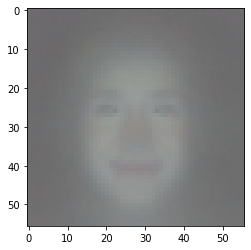

In [ ]:
plt.imshow(tf.reshape(U_rescaled[:, 1], (56, 56, 3)))

In [ ]:
eigenface_2_reshaped = tf.reshape(U_rescaled[:, 1], (56, 56, 3))

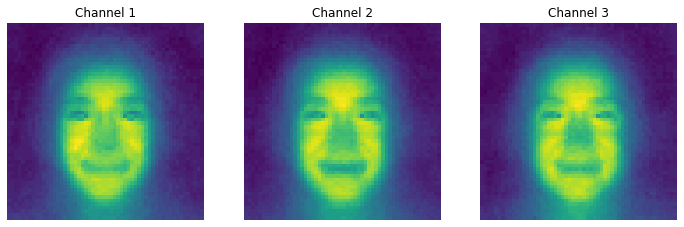

In [ ]:
fig_eigen_2 = plt.figure(figsize = (12, 8))
for i in range(3):
  a = fig_eigen_2.add_subplot(1, 3, i+1)
  imgplot = plt.imshow(eigenface_2_reshaped[:, :, i])
  a.set_title(f'Channel {i+1}')
  plt.axis('off')

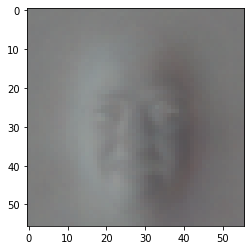

In [ ]:
plt.imshow(tf.reshape(U_rescaled[:, 2], (56, 56, 3)))

In [ ]:
eigenface_3_reshaped = tf.reshape(U_rescaled[:, 2], (56, 56, 3))

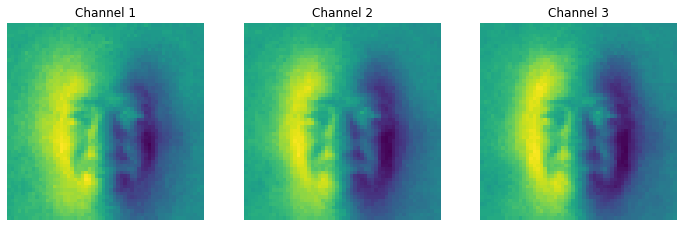

In [ ]:
fig_eigen_3 = plt.figure(figsize = (12, 8))
for i in range(3):
  a = fig_eigen_3.add_subplot(1, 3, i+1)
  imgplot = plt.imshow(eigenface_3_reshaped[:, :, i])
  a.set_title(f'Channel {i+1}')
  plt.axis('off')

It seems like eigenface 2 is about front lighting, while eigenface 3 is about lighting from one side.

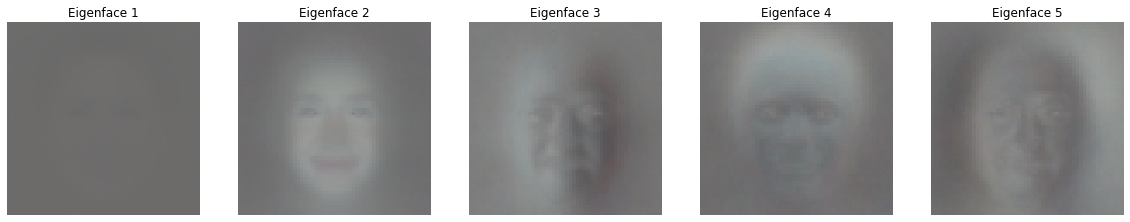

In [ ]:
fig2 = plt.figure(figsize = (20, 10))
for j in range(5):
    a = fig2.add_subplot(1, 5, j+1)
    imgplot = plt.imshow(tf.reshape(U_rescaled[:, j], (56, 56, 3)))
    a.set_title(f'Eigenface {j+1}')
    plt.axis("off")

From what we can see the first eigenfaces incode information about general face shape and lighting position.

In [ ]:
Vt[0]

<tf.Tensor: shape=(3072,), dtype=float32, numpy=
array([-0.01777818,  0.02077819, -0.01291139, ..., -0.00209273,
        0.01455264,  0.01102765], dtype=float32)>

In [ ]:
tf.reduce_max(Vt)

<tf.Tensor: shape=(), dtype=float32, numpy=0.90412265>

In [ ]:
tf.reduce_min(Vt)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.78175074>

In [ ]:
Vt_std = tf.math.reduce_std(Vt)
Vt_std

<tf.Tensor: shape=(), dtype=float32, numpy=0.018042196>

In [ ]:
tf.cast(tf.math.reduce_mean(Vt), dtype=tf.uint8)

<tf.Tensor: shape=(), dtype=uint8, numpy=0>

In [ ]:
faces_scaled_by_eigenvalues = tf.matmul(U, tf.linalg.diag(S), adjoint_b=True)

In [ ]:
faces_scaled_by_eigenvalues.shape

TensorShape([9408, 3072])

In [ ]:
faces_scaled_by_eigenvalues[0]

<tf.Tensor: shape=(3072,), dtype=float32, numpy=
array([-7.0680400e+03, -1.0368694e+03,  1.0797786e+02, ...,
       -3.9434500e+00,  2.5184631e+01,  4.6766844e+00], dtype=float32)>

In [ ]:
tf.reduce_min(faces_scaled_by_eigenvalues)

<tf.Tensor: shape=(), dtype=float32, numpy=-8812.417>

In [ ]:
tf.reduce_max(faces_scaled_by_eigenvalues)

<tf.Tensor: shape=(), dtype=float32, numpy=2799.879>

Let's check if we can reproduce one of the faces with the eigenfaces that we got from the SVD.

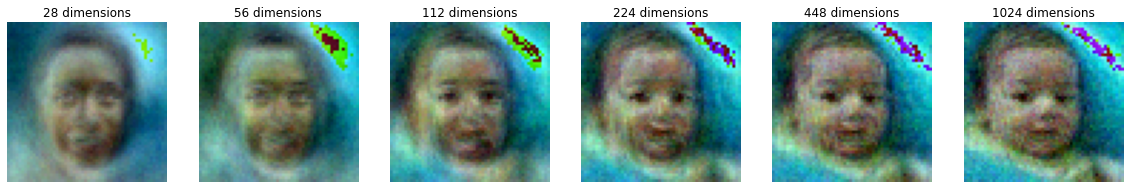

In [ ]:
r_list = [28, 56, 112, 224, 448, 1024]

fig_test_reconstructed_1 = plt.figure(figsize=(20, 20))
for i in range(len(r_list)):
    img = fig_test_reconstructed_1.add_subplot(1, 6, i+1)
    num_components = r_list[i]
    reconstructed_face = tf.cast(tf.linalg.matvec(U[:, :num_components], tf.linalg.matvec(tf.transpose(U[:, :num_components]), tf.cast(flattened_images[0], dtype=tf.float32))), dtype=tf.uint8)
    plt.imshow(tf.reshape(reconstructed_face, (56, 56, 3)))
    img.set_title(f"{r_list[i]} dimensions")
    plt.axis("off")

448 and even 224 dimensions seem to produce a pretty good representation of the actual image.
Let's try it out with one more image.

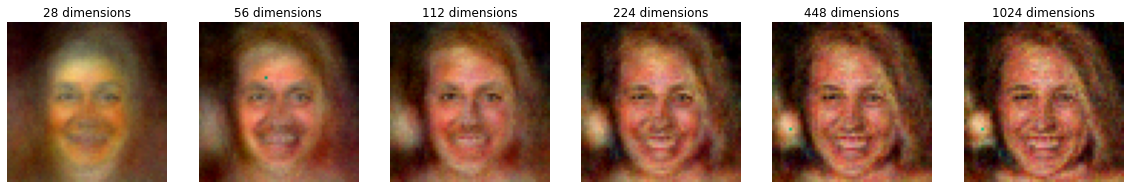

In [ ]:
r_list = [28, 56, 112, 224, 448, 1024]

fig_test_reconstructed_1 = plt.figure(figsize=(20, 20))
for i in range(len(r_list)):
    img = fig_test_reconstructed_1.add_subplot(1, 6, i+1)
    num_components = r_list[i]
    reconstructed_face = tf.cast(tf.linalg.matvec(U[:, :num_components], tf.linalg.matvec(tf.transpose(U[:, :num_components]), tf.cast(flattened_images[1], dtype=tf.float32))), dtype=tf.uint8)
    plt.imshow(tf.reshape(reconstructed_face, (56, 56, 3)))
    img.set_title(f"{r_list[i]} dimensions")
    plt.axis("off")

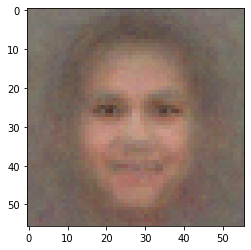

In [ ]:
num_components = 224

mean_face_approx = tf.cast(tf.linalg.matvec(U[:, :num_components], tf.linalg.matvec(tf.transpose(U[:, :num_components]), tf.cast(mean_image, dtype=tf.float32))), dtype=tf.uint8)
plt.imshow(tf.reshape(mean_face_approx, (56, 56, 3)))

The picture above is an approximation of the mean image of the data, using the eigenfaces.

Let's check what is the optimal number of dimensions or singular values, after which the data could be considered as noise.
This is explained in the Gavish-Donoho paper 'The Optimal Hard Threshold for Singular Values is 4/sqrt (3)'.

In [ ]:
def omega_approx(beta):
    """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

beta = min(image_matrix.shape) / max(image_matrix.shape)
tau = np.median(S) * omega_approx(beta)

Tau is the threshold for truncating the singular values.

In [ ]:
tau

8769.64599917329

In [ ]:
optimal_num_dimensions = len(S[S>=tau])
optimal_num_dimensions

362

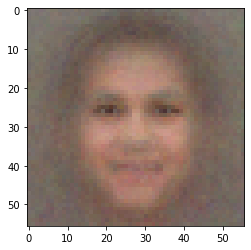

In [ ]:
mean_face_approx = tf.cast(tf.linalg.matvec(U[:, :optimal_num_dimensions], tf.linalg.matvec(tf.transpose(U[:, :optimal_num_dimensions]), tf.cast(mean_image, dtype=tf.float32))), dtype=tf.uint8)
plt.imshow(tf.reshape(mean_face_approx, (56, 56, 3)))

What if we try to construct a face using random noise and the first 362 principal components, which are the product of the first 362 components of U and the diagonal matrix S.

In [ ]:
optimal_U = U[:, :optimal_num_dimensions]
optimal_U.shape

TensorShape([9408, 362])

In [ ]:
optimal_S = tf.linalg.diag(S[:optimal_num_dimensions])
optimal_S.shape

TensorShape([362, 362])

In [ ]:
#principle_components = tf.transpose(tf.linalg.matvec(optimal_U, optimal_S))
principle_components = tf.linalg.matvec(optimal_S, optimal_U)
principle_components.shape

TensorShape([9408, 362])

In [ ]:
principle_components[:, 0]

<tf.Tensor: shape=(9408,), dtype=float32, numpy=
array([-7068.04 , -7122.993, -7567.263, ..., -7233.208, -7555.73 ,
       -7901.531], dtype=float32)>

Let's create a random fake component of Vt, which shows how much of each principal component would be in the image.

In [ ]:
fake_Vt_component = tf.random.normal([optimal_num_dimensions], stddev=Vt_std, dtype=tf.dtypes.float32)

In [ ]:
fake_Vt_batch = tf.random.normal([32, optimal_num_dimensions], stddev=Vt_std, dtype=tf.dtypes.float32)
fake_Vt_batch.shape

TensorShape([32, 362])

In [ ]:
fake_Vt_batch.shape[0]

32

In [ ]:
fake_faces_batch = tf.cast(tf.linalg.matvec(principle_components, fake_Vt_batch), dtype=tf.uint8)
fake_faces_batch.shape

TensorShape([32, 9408])

In [ ]:
tf.reduce_max(fake_faces_batch)

<tf.Tensor: shape=(), dtype=uint8, numpy=255>

In [ ]:
epsilon = tf.keras.backend.epsilon()

def collect_components(principle_components, fake_Vt_batch):
  collector_for_components = []
  for i in range(fake_Vt_batch.shape[0]):
    collector_for_1_image = []
    for j in range(optimal_num_dimensions):
      collector_for_1_image.append(tf.multiply(principle_components[:, j], fake_Vt_batch[i, j]))
    collector_for_1_image = tf.transpose(tf.stack(collector_for_1_image))
    collector_for_components.append(collector_for_1_image)
  collector_for_components = tf.stack(collector_for_components)
  # applying batch normalization
  collector_for_components = tf.divide(tf.subtract(collector_for_components, tf.reduce_mean(collector_for_components)), (tf.math.reduce_std(collector_for_components) + epsilon))
  collector_for_components = tf.reshape(collector_for_components, [fake_Vt_batch.shape[0], 56, 56, 3, optimal_num_dimensions])
  collector_for_components = tf.reshape(collector_for_components, [fake_Vt_batch.shape[0], 56, 56, optimal_num_dimensions*3])
  return collector_for_components

In [ ]:
collector_for_components = collect_components(principle_components, fake_Vt_batch)

In [ ]:
collector_for_components.shape

TensorShape([32, 56, 56, 1086])

As a result we get a batch of 32 images of size 56x56, each of which has 1086 channels, corresponding to 362 colour eigenfaces.

In [ ]:
tf.reduce_min(collector_for_components)

<tf.Tensor: shape=(), dtype=float32, numpy=-45.762787>

In [ ]:
tf.reduce_max(collector_for_components)

<tf.Tensor: shape=(), dtype=float32, numpy=34.07048>

In [ ]:
tf.reduce_mean(collector_for_components)

<tf.Tensor: shape=(), dtype=float32, numpy=-5.3764476e-10>

In [ ]:
tf.math.reduce_std(collector_for_components)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

Values are normalized to mean 0 and standard deviation 1.

In [ ]:
fake_Vt_components = tf.random.normal([len(eigen_images), optimal_num_dimensions], stddev=Vt_std, dtype=tf.dtypes.float32)
fake_Vt_components.shape

TensorShape([3072, 362])

In [ ]:
fake_faces = tf.cast(tf.linalg.matvec(principle_components, fake_Vt_components), dtype=tf.uint8)

In [ ]:
fake_faces.shape

TensorShape([3072, 9408])

In [ ]:
tf.reduce_min(fake_faces[15])

<tf.Tensor: shape=(), dtype=uint8, numpy=0>

In [ ]:
tf.reduce_max(fake_faces[15])

<tf.Tensor: shape=(), dtype=uint8, numpy=74>

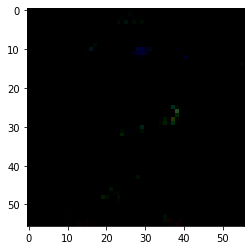

In [ ]:
plt.imshow(tf.reshape(fake_faces[15], (56, 56, 3)))

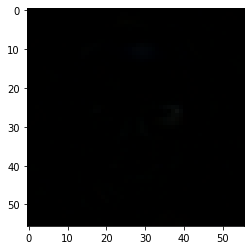

In [ ]:
fake_face = tf.cast(tf.linalg.matvec(U[:, :optimal_num_dimensions], tf.linalg.matvec(tf.transpose(U[:, :optimal_num_dimensions]), tf.cast(fake_faces[15], dtype=tf.float32))), dtype=tf.uint8)
plt.imshow(tf.reshape(fake_face, (56, 56, 3)))

Let's try it out with different number of dimensions.

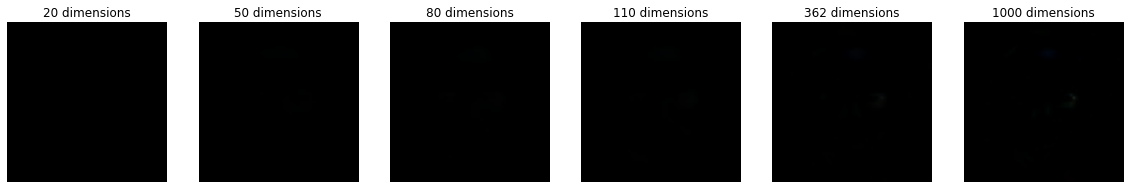

In [ ]:
r_list = [20, 50, 80, 110, optimal_num_dimensions, 1000]

fig_test_reconstructed_1 = plt.figure(figsize=(20, 20))
for i in range(len(r_list)):
    img = fig_test_reconstructed_1.add_subplot(1, 6, i+1)
    num_components = r_list[i]
    reconstructed_face = tf.cast(tf.linalg.matvec(U[:, :num_components], tf.linalg.matvec(tf.transpose(U[:, :num_components]), tf.cast(fake_faces[15], dtype=tf.float32))), dtype=tf.uint8)
    plt.imshow(tf.reshape(reconstructed_face, (56, 56, 3)))
    img.set_title(f"{r_list[i]} dimensions")
    plt.axis("off")

362 dimensions looks pretty good indeed. (In some versions of the notebook the random face appears black. This is an observation made on a successful random image.)



My hypothesis is that the generator will learn to produce realistic faces faster, because we are not giving it just random noise as an input, but the RGB channels of each of the 362 eigenfaces, normalized for each batch.

### Models

In [ ]:
#custom activation to map output of generator to values suitable for VGG entry (for VGG and VGGface version of the discriminator only)
def mapping_to_target_range(x, target_min=0, target_max=255):
    mean = [103.939, 116.779, 123.68]
    x02 = BK.tanh(x) + 1 # x in range(0,2)
    scale = (target_max-target_min)/2.0
    x_scaled = x02 * scale + target_min
    x_scaled = x_scaled[:, :, :, ::-1]
    x_centered_batch = []
    b = x_scaled[:, :, :, 0] - mean[0]
    g = x_scaled[:, :, :, 1] - mean[1]
    r = x_scaled[:, :, :, 2] - mean[2]
    x_centered_batch = tf.stack([b, g, r], axis=3)
    return x_centered_batch

In [ ]:
noise_test = tf.random.normal([32,224,224,3])
noise_test = mapping_to_target_range(noise_test)

In [ ]:
noise_test.shape

TensorShape([32, 224, 224, 3])

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.UpSampling2D(input_shape=(56, 56, 3*optimal_num_dimensions,)))
    assert model.output_shape == (None, 112, 112, 3*optimal_num_dimensions)

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 112, 112, 128)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 224, 224, 64)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation=tf.keras.activations.tanh))
    assert model.output_shape == (None, 224, 224, 3)

    return model

I tried using Conv2DTranspose in the generator, but this led to pixelated generated images. Hence I decided to substitute them for Upsampling2d + Conv2D layers, which led to a smoother representation.

In [ ]:
def denormalize_output(images):
  images = tf.cast(images * 127.5 + 127.5, dtype=tf.uint8)
  return images

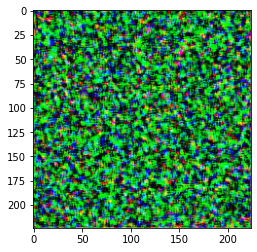

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1,56,56,3*optimal_num_dimensions])
generated_image = generator(noise, training=False)
generated_image_RGB = denormalize_output(generated_image)
plt.imshow(generated_image_RGB[0, :, :, :])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 112, 112, 1086)    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 128)     3475328   
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 128)     512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 128)     0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 224, 224, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      2

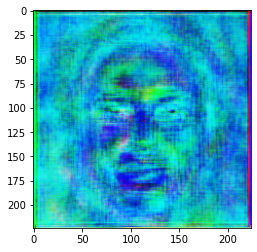

In [ ]:
generated_images_fake = generator(collector_for_components, training=False)
x_RGB = denormalize_output(generated_images_fake)
plt.imshow(x_RGB[0, :, :, :])

We can clearly recognize a random face structure in the output noise before training.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=(224, 224, 3,)))
    assert model.output_shape == (None, 224, 224, 64)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 112, 112, 128)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3*optimal_num_dimensions, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 56, 56, 3*optimal_num_dimensions)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_images_fake)
print (decision)

tf.Tensor(
[[0.49724248]
 [0.4981352 ]
 [0.50331014]
 [0.49968842]
 [0.49766266]
 [0.49763763]
 [0.48661128]
 [0.4978965 ]
 [0.49207804]
 [0.48866984]
 [0.49503425]
 [0.5034342 ]
 [0.48886508]
 [0.5034961 ]
 [0.4909768 ]
 [0.4969784 ]
 [0.49759164]
 [0.4966626 ]
 [0.49969786]
 [0.49131694]
 [0.4931986 ]
 [0.49126416]
 [0.4874802 ]
 [0.4888284 ]
 [0.4841848 ]
 [0.49668464]
 [0.4957137 ]
 [0.48995525]
 [0.49597606]
 [0.49109742]
 [0.49032137]
 [0.49685845]], shape=(32, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 1086)     

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
real_acc = tf.keras.metrics.Accuracy()
fake_acc = tf.keras.metrics.Accuracy()
def discriminator_accuracy(real_output, fake_output):
    real_acc.update_state(tf.ones_like(real_output), real_output)
    fake_acc.update_state(tf.zeros_like(fake_output), fake_output)
    return real_acc.result(), fake_acc.result()

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

I tried different configurations for the optimizers:


*   Adam for both with learning rates: 1e-3; 1e-4; 1,5e-4; 5e-4; 1e-5
*   I tried both the same and different learning rates for the generator and the discriminator. Bigger learning rate for the discriminator didn't lead to good outcome - the accuracy of the discriminator was close to 0.0. Bigger learning rate for the generator and smaller for the discriminator (1e-3 for generator and 1e-4 for discriminator) led to fast and stable training in my opinion and maybe got better at generating faces faster. I am showcasing the equal scenario here, because I ran more epochs on it and has a similar quality in my opinion.


*   I tried the default value 0.9 of the momentum in the Adam optimizer at first, but decreasing it to 0.5 led to fewer oscillations in a single face when tracking it over many epochs
*   I tried SGD for the discriminator, but it didn't seem to work so well. I ran only 10 epochs on it though.





In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

In [ ]:
checkpoint_dir = '/content/gdrive/My Drive/EigenDCGAN/checkpoints/checkpoints0006'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '/content/gdrive/My Drive/EigenDCGAN/checkpoints/logs0006_9/'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

I am running 10 epochs at a time. In this case I have run 10 times 10 epochs, a total of 100 epochs, approximately 330 seconds each. I was saving a checkpoint every 5 epochs and I have saved the generator and discriminator models as well.

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, optimal_num_dimensions], stddev=Vt_std, dtype=tf.dtypes.float32)
seed = collect_components(principle_components, seed)

In [ ]:
seed.shape

TensorShape([16, 56, 56, 1086])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, optimal_num_dimensions], stddev=Vt_std, dtype=tf.dtypes.float32)
    noise = collect_components(principle_components, noise)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      real_acc, fake_acc = discriminator_accuracy(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, real_acc, fake_acc

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    real_acc_list = []
    fake_acc_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      real_acc_list.append(t[2])
      fake_acc_list.append(t[3])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    real_accuracy = sum(real_acc_list) / len(real_acc_list)
    fake_accuracy = sum(fake_acc_list) / len(fake_acc_list)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    with train_summary_writer.as_default():
      tf.summary.scalar('generator loss', g_loss, step=epoch)
      tf.summary.scalar('discriminator loss', d_loss, step=epoch)
      tf.summary.scalar('real accuracy', real_accuracy, step=epoch)
      tf.summary.scalar('fake accuracy', fake_accuracy, step=epoch)

    print (f'Epoch {epoch+1}, gen_loss={g_loss}, disc_loss={d_loss}, real_acc={real_accuracy}, fake_acc={fake_accuracy}')
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  predictions = denormalize_output(predictions)

  fig = plt.figure(figsize=(16, 16))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(90+epoch))
  plt.show()

In [ ]:
generator = tf.keras.models.load_model('/content/gdrive/My Drive/EigenGAN/checkpoints/models5_1/')

In [ ]:
discriminator = tf.keras.models.load_model('/content/gdrive/My Drive/EigenGAN/checkpoints/models5_1_discriminator/')

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 112, 112, 1086)    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 128)     3475328   
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 128)     512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 128)     0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 224, 224, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      2

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 1086)     

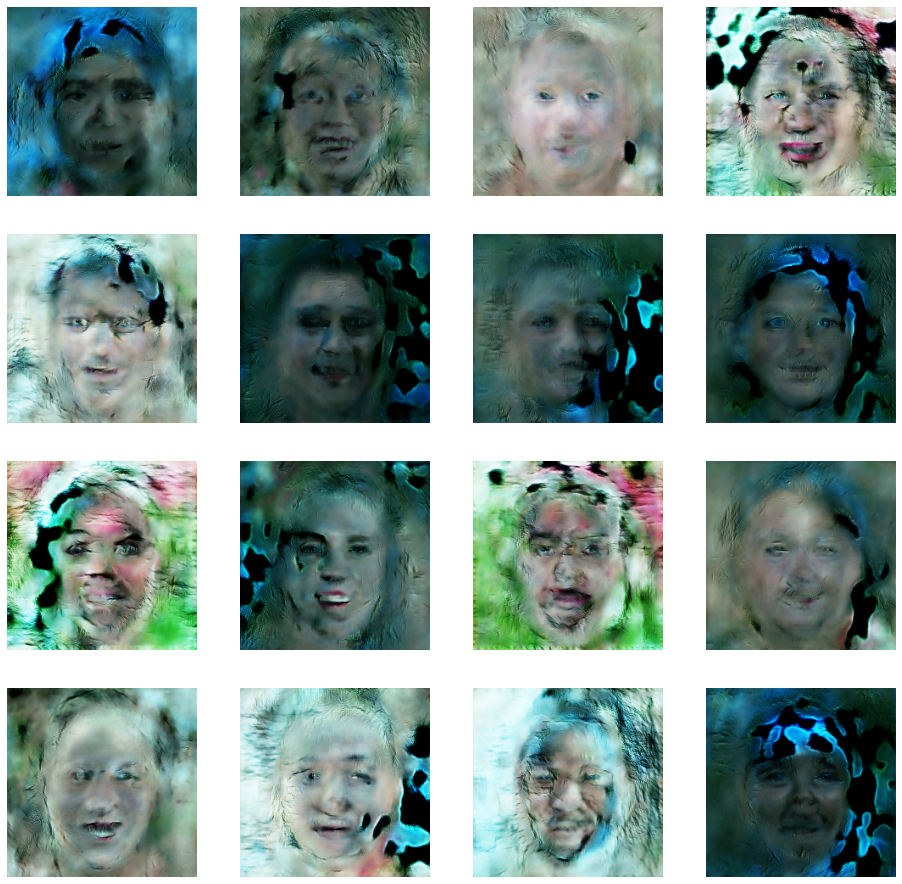

In [ ]:
train(train_dataset, EPOCHS)

The above is the result after 100 epochs of training.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# display_image(1)

In [ ]:
anim_file = 'eigen_dcgan0006_9.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir '/content/gdrive/My Drive/EigenDCGAN/checkpoints/logs0006_9/'

<IPython.core.display.Javascript object>

In [ ]:
# generator.save(os.path.join('/content/gdrive/My Drive/EigenDCGAN/checkpoints/models0006_3/', "face_generator.h5"))

In [ ]:
# discriminator.save(os.path.join('/content/gdrive/My Drive/EigenDCGAN/checkpoints/models0006_3/', "face_discriminator.h5"))

In [ ]:
generator.save('/content/gdrive/My Drive/EigenDCGAN/checkpoints/models0006_9_generator/')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/EigenDCGAN/checkpoints/models0006_9_generator/assets


In [ ]:
discriminator.save('/content/gdrive/My Drive/EigenDCGAN/checkpoints/models0006_9_discriminator/')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/EigenDCGAN/checkpoints/models0006_9_discriminator/assets


The following is a link to the saved models and Tensorboard logs (the downside is there is a separate logs file for each 10 epochs):
https://drive.google.com/drive/folders/1DZonL_f1VaFfhpGyh4fNBn1QvvtCqW9r?usp=sharing
Owner of the folder is my father, because I worked on his laptop as well. :)

### Conclusion

I think the experiment of generating images with EigenGAN proved successful, though further work needs to be done in comparing the number of parameters needed for a generator and the quality of output in cases where we use the eigenface approach versus the original n-dimensional vector approach.
Further work needs to be done in the fine-tuning, so that the network can converge and produce realistic images.
There is one more thing to take into consideration: the amount of training data I can use proved to be a limitation for me, because of the limited resources I was using - a single GPU in Google Colab and restricted amount of space on my Google Drive. Further work can be done to check if the network performs better with more training data.

### Resources

1. Unsupervised representation learning with Deep Convolutional Generative Adversarial Networks. Alec Radford & Luke Metz, Soumith Chintala (2016)

2. Image-to-Image Translation with Conditional Adversarial Networks. Phillip Isola, Jun-Yan Zhu, Tinghui Zhou, Alexei A. Efros (2016)

3. Towards principled methods for training Generative Adversarial Networks. Martin Arjovsky, Leon Bottou

4. Stabilizing training of Generative Adversarial Networks through regularization. Kevin Roth, Aurelien Lucchi, Sebastian Nowozin, Thomas Hofmann (2017)

5. Generative Image Modeling using Style and Structure Adversarial Networks. Xiaolong Wang, Abhinav Gupta (2016)

6. https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb

7. https://github.com/soumith/ganhacks

8. Tensorflow / Keras website

9. Generative Adversarial Nets. Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio (2014)

